# Example 2: Two-parameter EKI

In this example, we will code the mean-filed dynamocal system formulation of EKI and apply it to
2-parameter inversion for linear systems.

We implement here the original, iterative ensemble Kalman filter as formulated in [@Stuart2013].

Recall the inverse problem: recover the unknown $u$ from noisy measurements $y$ related by

$$
  y = \mathcal{G}(u) + \eta,
$$
where the noise $\eta \sim \mathcal{N}(0, \Gamma).$

Start by introducing a pseudo time, $h = 1/N,$ and then propagate an ensemble $\{ u_n^{(j)}\}$ of $J$ particles (ensemble members) from "time" $nh$ to $(n+1)h$ according to

$$
   u_{n+1}^{(j)} =  u_n^{(j)} + C^{up}(u_n) \left[ C^{pp}(u_n) + \frac{1}{h} \Gamma \right]^{-1} 
                    \left( y_{n+1}^{(j)} -  \mathcal{G}(u_n^{(j)}) \right),
$$

where

$$
\begin{align}
   C^{pp}(u) &= \frac{1}{J-1} \sum_{j=1}^{J} \left(  \mathcal{G}(u^{(j)} - \hat{\mathcal{G}}  \right) \otimes
                 \left(  \mathcal{G}(u^{(j)} - \hat{\mathcal{G}}  \right) \\
   C^{up}(u) &= \frac{1}{J-1} \sum_{j=1}^{J} \left( u^{(j)} - \hat{u}  \right) \otimes
                 \left(  \mathcal{G}(u^{(j)} - \hat{\mathcal{G}}  \right)  \\
   \hat{u} &= \frac{1}{J} \sum_{j=1}^{J} u^{(j)}, \qquad  \hat{\mathcal{G}} =  \frac{1}{J} \sum_{j=1}^{J}  \mathcal{G}(u^{(j)}) .
\end{align}
$$

In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt
from functools import partial

## Implement the one-dimensional EKI for a linear forward operator $\mathcal{G}$

In [48]:
def eki_one_dim_lin(m_0, C_0, N, G, gamma, y, delt, h):
    # Inputs:
    # -------
    # m_0, C_0: mean value and covariance of inital ensemble
    # N:        number of iterations
    # G:        one-dimensional forward operator of the model
    # gamma:    covariance of the noise in the data
    # y:        observed data 
    # h:        discretization step  
    #
    # Outputs:
    # -------
    # U: (JxN) matrix with the computed particles for each iteration
    # m: vector of length N with the mean value of the particles
    # C: vector of length N with the covariance of the particles
    
    m = np.zeros(N)
    C = np.zeros(N)
    U = np.zeros((J,N))
    
    #Construct initial ensemble and estimator
    u_0 = np.random.normal(m_0, C_0, J)
    U[:,0] = u_0
    m[0] = np.mean(U[:,0])
    C[0] = (U[:,0] - m[0]) @ (U[:,0] - m[0]).T / (J-1)
    
    for n in range(1,N):
        
        # Last iterate under forward operator:
        G_u    = G*U[:, n-1]
        Ghat   = np.mean(G_u)
        U[:,n] = U[:,n-1] + h*(C[n-1] + delt)*G*(1/gamma)*((y - G_u))
        
        m[n] = np.mean(U[:,n])
        C[n] = (U[:,n] - m[n]) @ (U[:,n] - m[n]).T / (J-1)
            
    return U,m,C

In [49]:
#Set Parameters
J = 10
gamma = 1
m_0 = 0
C_0 = 9e-1
m_true = 0
c_true = C_0
G = 1.5
N = 10000
h = 1/100
delt = 1

# Construct data under true parameter
u_true = np.random.normal(m_true,c_true)
y = G*u_true

U,m,c = eki_one_dim_lin(m_0, C_0, N, G, gamma, y, delt, h)

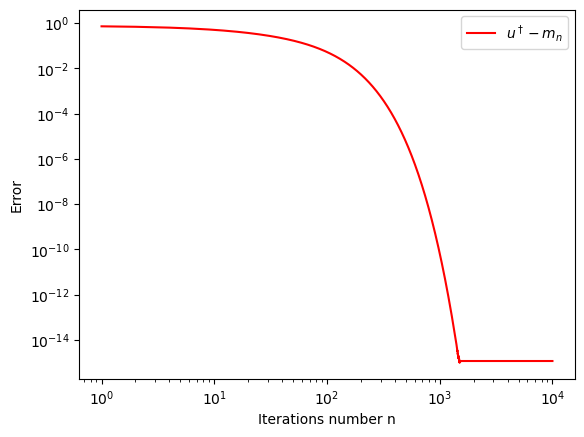

In [50]:
it=N
iterations=list(range(1,(it+1)))
plt.xlabel('Iterations number n')
plt.ylabel('Error')
plt.loglog(iterations,np.sqrt((u_true*np.ones(N) - m)**2/(u_true**2)),"r",label='$u^\dagger-m_n$')
plt.legend(loc="upper right")
plt.show()

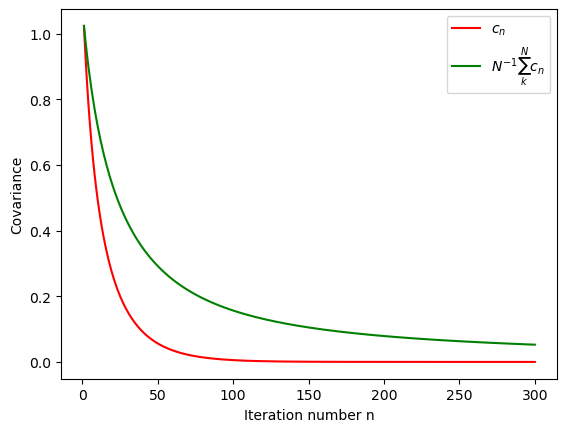

In [51]:
it=300
iterations=list(range(1,it+1))
plt.xlabel('Iteration number n')
plt.ylabel('Covariance')
plt.plot(iterations,c[0:it],"r", label='$c_n$')
plt.plot(iterations,np.divide(np.cumsum(c[0:it]),iterations)[0:it],"g",label='$N^{-1}\sum_k^N c_n$')
plt.legend(loc="upper right")
plt.show()

## Implement the one dimensional EKI for an arbitrary forward operator $\mathcal{G}$

In [19]:
def eki_one_dim(m_0, C_0, N, G, gamma, y, h):
    # Inputs:
    # -------
    # m_0, C_0: mean value and covariance of inital ensemble
    # N:        number of iterations
    # G:        one-dimensional forward operator of the model
    # gamma:    covariance of the noise in the data
    # y:        observed data 
    # h:        discretization step  
    #
    # Outputs:
    # -------
    # U: (JxN) matrix with the computed particles for each iteration
    # m: vector of length N with the mean value of the particles
    # C: vector of length N with the covariance of the particles
        
    m = np.zeros(N)
    C = np.zeros(N)
    U = np.zeros((J,N))
    
    #Construct initial ensemble and estimator
    u_0 = np.random.normal(m_0, C_0, J)
    U[:,0] = u_0
    m[0] = np.mean(U[:,0])
    C[0] = (U[:,0] - m[0]) @ (U[:,0] - m[0]).T / (J-1)
    
    for n in range(1,N):
        
        # Last iterate under forward operator:
        G_u = G(U[:,n-1])
        uhat = np.mean(U[:,n-1])
        Ghat = np.mean(G_u)
        
        cov_up = (U[:,n-1] - uhat) @ (G_u - Ghat).T / (J-1)
        cov_pp = (G_u - Ghat) @ (G_u - Ghat).T / (J-1)
        
        U[:,n] = U[:,n-1] + cov_up*h/(h*cov_pp + gamma)*(y - G_u)        
        
        m[n] = np.mean(U[:,n])
        C[n] = (U[:,n]-m[n])@(U[:,n]-m[n]).T/(J-1)
            
    return U, m, C

In [43]:
#Set Parameters
J = 10
r = 10
k = 10
gamma = 1
m_0 = 0
C_0 = 9e-2
m_true = 0
C_true = C_0
N = 10000
h = 1/100 # 1/N

def forward_log(z, k, r, h):
    return k/(1 + np.exp(-r*k*h)*(k/z-1))

# Construct data under true parameter
u_true = np.random.normal(m_true, C_true)
y = forward_log(u_true, k, r, h)

# Use partial function
partial_log = functools.partial(forward_log, k=10, r=10, h=1/100)

U, m, C = eki_one_dim(m_0, C_0, N, partial_log, gamma, y, h)

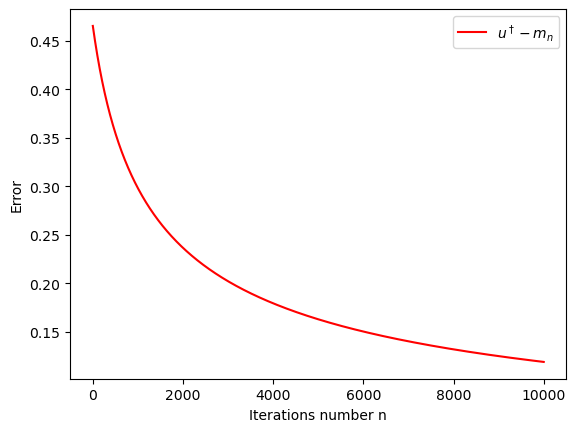

In [47]:
it = N
iterations=list(range(1,it+1))
plt.xlabel('Iterations number n')
plt.ylabel('Error')
plt.plot(iterations,np.sqrt((u_true*np.ones(N) - m)**2/(u_true**2)),"r", label='$u^\dagger-m_n$')
plt.legend(loc="upper right")
plt.show()

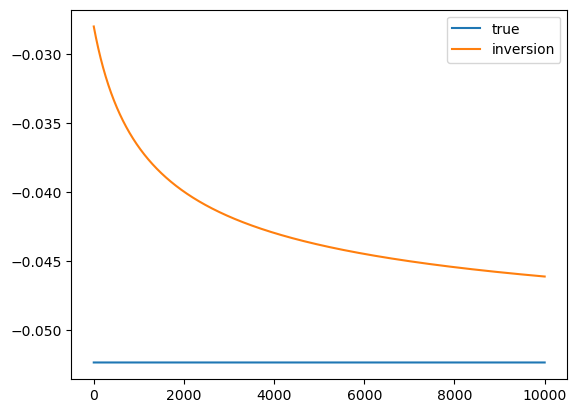

In [45]:
plt.plot(iterations, u_true*np.ones(N), label="true")
plt.plot(iterations, m, label="inversion")
plt.legend()
plt.show()

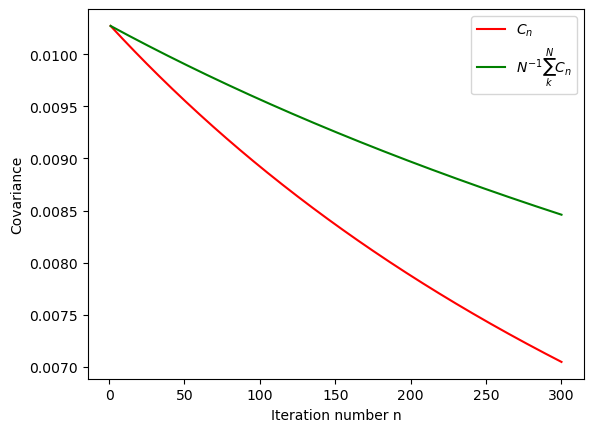

In [46]:
it = 300
iterations = list(range(1,it+1))
plt.xlabel('Iteration number n')
plt.ylabel('Covariance')
plt.plot(iterations,C[0:it],"r", label='$C_n$')
plt.plot(iterations,np.divide(np.cumsum(C[0:it]),iterations)[0:it],"g",label='$N^{-1}\sum_k^N C_n$')
plt.legend(loc="upper right")
plt.show()

## Conclusions

The converegence is very slow, and not very accurate. This will be remedied by the mean-field approach.